In [39]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns

from sklearn.metrics import confusion_matrix

In [40]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [41]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [42]:
# Створимо нейронну мережу
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name='w'
        )
        self.b = tf.Variable(tf.zeros([out_features]), name='b')

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        # Вихідний шар
        self.out_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer1(x, activation=1)
        x = self.layer2(x, activation=1)
        return self.out_layer(x, activation=1)

In [43]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    predicted_class = tf.argmax(y_pred, 1)
    y_true = tf.cast(y_true, tf.int64)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_class, y_true), tf.float32))
    return accuracy

In [44]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name='mnist')

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return pred, loss    

In [50]:
# Тренування мережі
loss_history = []
accuracy_history = []

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    pred, loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f'Шаг: {step}, Втрати: {loss}, Точність: {acc}')

# Тестування моделі
pred_test = neural_net(x_test)
test_acc = accuracy(pred_test, y_test)
print(f'Тестування точності: {np.round(test_acc, 4)}')

Шаг: 100, Втрати: 262.87158203125, Точність: 0.57421875
Шаг: 200, Втрати: 278.312744140625, Точність: 0.53125
Шаг: 300, Втрати: 246.34640502929688, Точність: 0.5234375
Шаг: 400, Втрати: 254.96107482910156, Точність: 0.62109375
Шаг: 500, Втрати: 264.6029968261719, Точність: 0.5625
Шаг: 600, Втрати: 249.31378173828125, Точність: 0.6015625
Шаг: 700, Втрати: 230.077392578125, Точність: 0.58203125
Шаг: 800, Втрати: 255.2922821044922, Точність: 0.55859375
Шаг: 900, Втрати: 272.6495361328125, Точність: 0.5
Шаг: 1000, Втрати: 264.3287353515625, Точність: 0.54296875
Шаг: 1100, Втрати: 221.92105102539062, Точність: 0.57421875
Шаг: 1200, Втрати: 234.4534912109375, Точність: 0.59765625
Шаг: 1300, Втрати: 262.6266784667969, Точність: 0.609375
Шаг: 1400, Втрати: 249.117431640625, Точність: 0.57421875
Шаг: 1500, Втрати: 244.79566955566406, Точність: 0.609375
Шаг: 1600, Втрати: 242.65765380859375, Точність: 0.5859375
Шаг: 1700, Втрати: 238.7411346435547, Точність: 0.59765625
Шаг: 1800, Втрати: 228.830

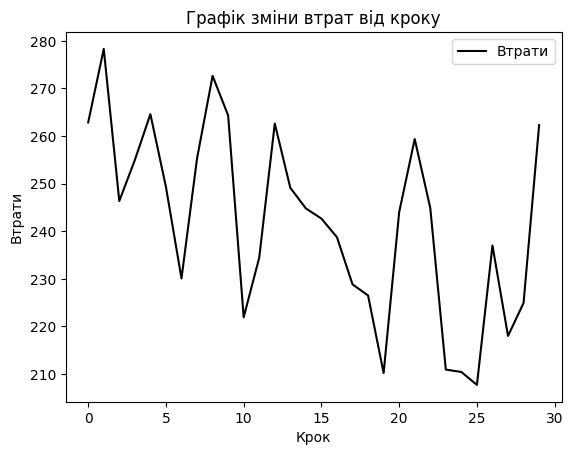

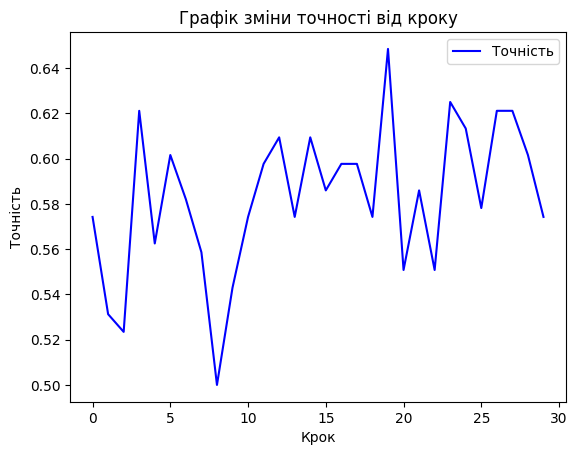

In [51]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

# Виведіть графік функції втрат
plt.plot(loss_history, label='Втрати', color='black')
plt.title('Графік зміни втрат від кроку')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.legend()
plt.show()

# Виведіть графік точності
plt.plot(accuracy_history, label='Точність', color='blue')
plt.title('Графік зміни точності від кроку')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.legend()
plt.show()

Точність на тестових даних: 0.5778999924659729


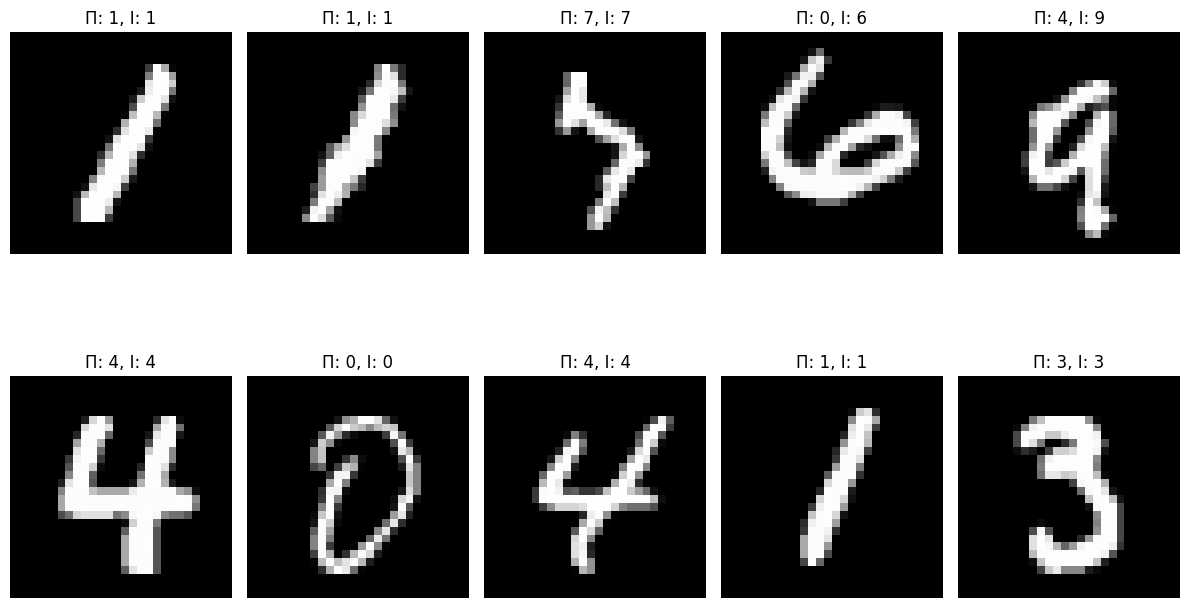

In [63]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Обчисліть точність навченої нейромережі
pred_test = neural_net(x_test)
test_acc = accuracy(pred_test, y_test)
print(f'Точність на тестових даних: {np.round(test_acc, 4)}')

# Тестування моделі на тестових даних
num_images_to_test = 10
random_indices = np.random.choice(len(x_test), num_images_to_test, replace=False)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]

predicted_labels = neural_net(images_to_test).numpy().argmax(axis=1)

plt.figure(figsize=(12, 8))
for i in range(num_images_to_test):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_to_test[i].reshape((28, 28)), cmap='gray')
    plt.title(f'П: {predicted_labels[i]}, І: {labels_to_test[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()